# 0. Get the data

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2021-04-16 19:14:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M  64.9MB/s    in 2.9s    

2021-04-16 19:14:59 (64.9 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2021-04-16 19:14:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tm

# 1. Create a CallBack

In [2]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.75):
      print("\nReached 75% validation accuracy so cancelling training!")
      self.model.stop_training = True


callbacks = myCallback()

# 2. Load data and EDA

## Load

In [3]:
from zipfile import ZipFile
import os

train_location = '/tmp/rps.zip'
zip_ref = ZipFile(train_location, 'r')
zip_ref.extractall('/tmp/rps')
train = '/tmp/rps/rps'

validation_location = '/tmp/rps-test-set.zip'
zip_ref = ZipFile(validation_location, 'r')
zip_ref.extractall('/tmp/rps')
validation = '/tmp/rps/rps-test-set'

In [4]:
import os 
train_paper_dir = os.path.join(train, 'paper')
train_rock_dir = os.path.join(train, 'rock')
train_scissors_dir = os.path.join(train, 'scissors')

val_paper_dir = os.path.join(validation, 'paper')
val_rock_dir = os.path.join(validation, 'rock')
val_scissors_dir = os.path.join(validation, 'scissors')

train_paper_names = os.listdir(train_paper_dir)
train_rock_names = os.listdir(train_rock_dir)
train_scissors_names = os.listdir(train_scissors_dir)

val_paper_names = os.listdir(val_paper_dir)
val_rock_names = os.listdir(val_rock_dir)
val_scissors_names = os.listdir(val_scissors_dir)

## EDA

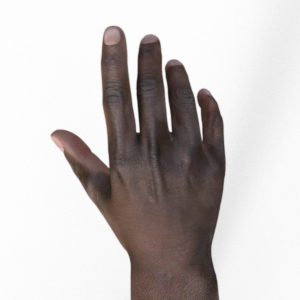

In [6]:
from tensorflow.keras.preprocessing.image import load_img
image = os.path.join(train_paper_dir, train_paper_names[10])
image = load_img(image)
image

In [7]:
print(image)

<PIL.Image.Image image mode=RGB size=300x300 at 0x7F4B201D8950>


In [8]:
from numpy import asarray
asarray(image)[1][1]

array([253, 253, 253], dtype=uint8)

In [11]:
for x in [train_paper_names, train_rock_names, train_scissors_names]:
  print(len(x))

840
840
840


In [12]:
for x in [val_paper_names, val_rock_names, val_scissors_names]:
  print(len(x))

124
124
124


# 3. Define the model

In [13]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=RMSprop(lr=1e-4)
)

# 4. Image pre-process

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    train, target_size=(150,150), batch_size=20, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
    validation, target_size=(150,150), batch_size=12, class_mode='categorical')

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## 5. Fit the model

In [18]:
history = model.fit(
    train_generator, 
    steps_per_epoch=126,
    epochs=100,
    validation_data=val_generator,
    validation_steps=31,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/100
126/126 - 10s - loss: 0.8880 - accuracy: 0.6950 - val_loss: 0.7813 - val_accuracy: 0.6595
Epoch 2/100
126/126 - 9s - loss: 0.2941 - accuracy: 0.7730 - val_loss: 0.3724 - val_accuracy: 0.7025
Epoch 3/100
126/126 - 9s - loss: 0.0904 - accuracy: 0.8249 - val_loss: 0.2163 - val_accuracy: 0.7966

Reached 60% accuracy so cancelling training!


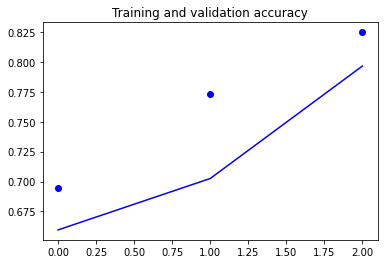

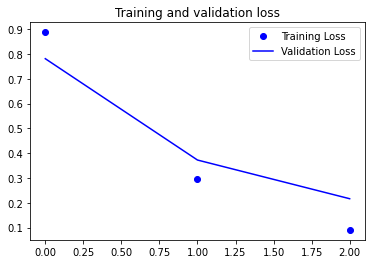

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Training and validation accuracy')

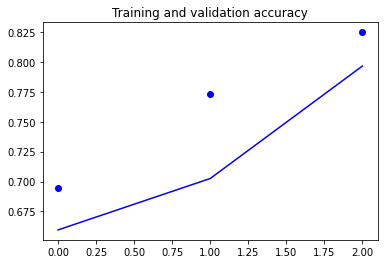

In [20]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

# Repeat all the process doing transformations of the data

In [22]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.85):
      print("\nReached 85% validation accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=RMSprop(lr=1e-4)
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train, target_size=(150,150), batch_size=20, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
    validation, target_size=(150,150), batch_size=12, class_mode='categorical')

history = model.fit(
    train_generator, 
    steps_per_epoch=126,
    epochs=100,
    validation_data=val_generator,
    validation_steps=31,
    verbose=2,
    callbacks=[callbacks]
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Epoch 1/100
126/126 - 24s - loss: 1.0529 - accuracy: 0.4270 - val_loss: 0.9525 - val_accuracy: 0.3952
Epoch 2/100
126/126 - 24s - loss: 0.8351 - accuracy: 0.6302 - val_loss: 0.6800 - val_accuracy: 0.7285
Epoch 3/100
126/126 - 23s - loss: 0.6822 - accuracy: 0.6960 - val_loss: 0.3617 - val_accuracy: 0.9409

Reached 85% validation accuracy so cancelling training!
